In [1]:
import pandas as pd
import altair as alt


In [2]:
# Handle large data sets by not embedding them in the notebook
alt.data_transformers.enable('data_server')

# Save a PNG blob as a backup for when the Altair plots do not render
alt.renderers.enable('mimetype')
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'svg'])

RendererRegistry.enable('altair_saver')

In [3]:
stock_price_trend_df = pd.read_csv('../data/prices_trends_merged_data.csv')

In [4]:
stock_price_trend_df

,week,weekly_interest,symbol,open,adj_close
0,2020-07-05,40,FOX,26.940001,24.860155
1,2020-07-12,44,FOX,25.379999,24.732868
2,2020-07-19,44,FOX,25.080000,25.937201
3,2020-07-26,46,FOX,26.379999,25.232225
4,2020-08-02,45,FOX,25.870001,24.370590
...,...,...,...,...,...
17467,2021-05-30,55,BLK,887.900024,878.887817
17468,2021-06-06,79,BLK,888.659973,876.834106
17469,2021-06-13,42,BLK,881.000000,837.127441
17470,2021-06-20,67,BLK,849.000000,870.232971


In [5]:
# Calculating the weekly price change as a percentage
stock_price_trend_df['price_change_pct'] = (stock_price_trend_df['adj_close'] - stock_price_trend_df['open']) / stock_price_trend_df['open']
stock_price_trend_df

,week,weekly_interest,symbol,open,adj_close,price_change_pct
0,2020-07-05,40,FOX,26.940001,24.860155,-0.077203
1,2020-07-12,44,FOX,25.379999,24.732868,-0.025498
2,2020-07-19,44,FOX,25.080000,25.937201,0.034179
3,2020-07-26,46,FOX,26.379999,25.232225,-0.043509
4,2020-08-02,45,FOX,25.870001,24.370590,-0.057959
...,...,...,...,...,...,...
17467,2021-05-30,55,BLK,887.900024,878.887817,-0.010150
17468,2021-06-06,79,BLK,888.659973,876.834106,-0.013308
17469,2021-06-13,42,BLK,881.000000,837.127441,-0.049799
17470,2021-06-20,67,BLK,849.000000,870.232971,0.025009


In [6]:
# Calculating the standard deviation of the price change percentage for each stock
stock_price_stds = stock_price_trend_df.groupby('symbol').agg({'price_change_pct': 'std'})
stock_price_stds

,price_change_pct
symbol,
AAL,0.062810
AAP,0.037851
AAPL,0.041034
ABBV,0.030771
ABC,0.035948
...,...
T,0.030373
TAP,0.042804
TECH,0.047673


In [7]:
# Plotting the standard deviations of the price change percentages for all stocks as a distribution
plt_price_stds = alt.Chart(stock_price_stds, title='Distribution of the weekly price change percentage').mark_bar().encode(
    x = alt.X('price_change_pct', bin=alt.Bin(maxbins=100), title='Stock Price Percentage Change(Standard Deviations)'),
    y = 'count()',
)


In [8]:
# Calculating the standard deviation of the weekly interest on google trends for each stock
stock_trends_stds = stock_price_trend_df.groupby('symbol').agg({'weekly_interest': 'std'})
stock_trends_stds

,weekly_interest
symbol,
AAL,17.817017
AAP,16.372318
AAPL,15.370438
ABBV,17.497716
ABC,8.776082
...,...
T,5.656454
TAP,12.784367
TECH,10.329781


In [9]:
# Plotting the standard deviations of the price change percentages for all stocks as a distribution
plt_trends_stds = alt.Chart(stock_trends_stds, title='Distribution of the weekly search interest').mark_bar().encode(
    x = alt.X('weekly_interest', bin=alt.Bin(maxbins=100), title='Weekly Interest on Google Trends(Standard Deviations)'),
    y = 'count()')


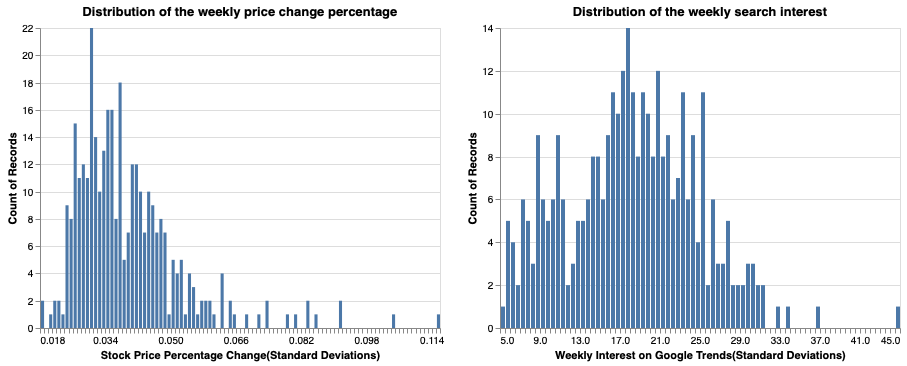

In [10]:
plt_price_stds | plt_trends_stds

In [11]:
# Calculating the standard deviation of the weekly interest on google trends and price change percentage for each stock
stock_trends_prices_stds = stock_price_trend_df.groupby('symbol').agg({'weekly_interest': 'std', 'price_change_pct': 'std'})
stock_trends_prices_stds

,weekly_interest,price_change_pct
symbol,,
AAL,17.817017,0.062810
AAP,16.372318,0.037851
AAPL,15.370438,0.041034
ABBV,17.497716,0.030771
ABC,8.776082,0.035948
...,...,...
T,5.656454,0.030373
TAP,12.784367,0.042804
TECH,10.329781,0.047673


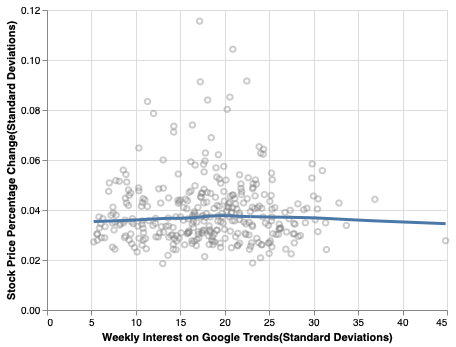

In [12]:
plt_trends_prices_stds = alt.Chart(stock_trends_prices_stds).mark_point(opacity=0.4, color='gray').encode(
    x=alt.X('weekly_interest', title='Weekly Interest on Google Trends(Standard Deviations)'),
    y=alt.Y('price_change_pct', title='Stock Price Percentage Change(Standard Deviations)')
)

plt_trends_prices_stds + plt_trends_prices_stds.transform_loess('weekly_interest', 'price_change_pct', bandwidth=0.8).mark_line(size=3)